# Background Removal using SVD

In [1]:
import numpy as np
from PIL import Image
import moviepy.editor as mpe

%matplotlib inline
import matplotlib.pyplot as plt

# For error: TypeError: must be real number, not NoneType -> pgrade moviepy (and pip)
video = mpe.VideoFileClip('resources/Video_003.avi')
video.subclip(0, 60).ipython_display(width=300)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Converting video to matrix

Unroll a frame into a single tall column with height = 240x320 = 76800.

Stack the columns to create matrix. Number of columns = duration of clip * number of frames per second

Video duration: 113.57 seconds
Old frame dimensions: [240 320]
New frame dimensions: [240 320]
Size of M: (76800, 565)


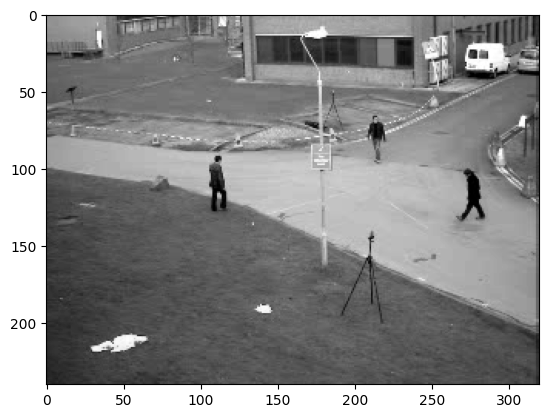

In [2]:
print("Video duration:", video.duration, "seconds")

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def resize_image(img, resolution):
    size = tuple((np.array(img.size)*resolution).astype(int))
    new_img = np.array(img.resize(size))
    return new_img

def create_matrix_from_video(clip, k = 10, resolution=0.5):
    """
    @param k => number of frames per second
    @param resolution => percentage resolution
    """
    frames = [clip.get_frame(i/k) for i in range (k * int(clip.duration))]
    frames = [rgb2gray(frame).astype(int) for frame in frames]
    frames = [Image.fromarray(np.uint8(frame), 'L') for frame in frames]
    frames = [resize_image(frame, resolution).flatten() for frame in frames]
    return np.vstack(frames).T


resolution = 1
k = 5
dims = video.get_frame(0).shape
dims = np.array((dims[0], dims[1]))
M = create_matrix_from_video(video, k, resolution)
# M = np.load("video_matrix.npy")

new_dims = (dims*resolution).astype(int)

print("Old frame dimensions:", dims)
print("New frame dimensions:", new_dims)
print("Size of M:", M.shape)
plt.imshow(np.reshape(M[:, 0], new_dims), cmap='gray')

# np.save("video_matrix.npy", M)

(76800, 565)


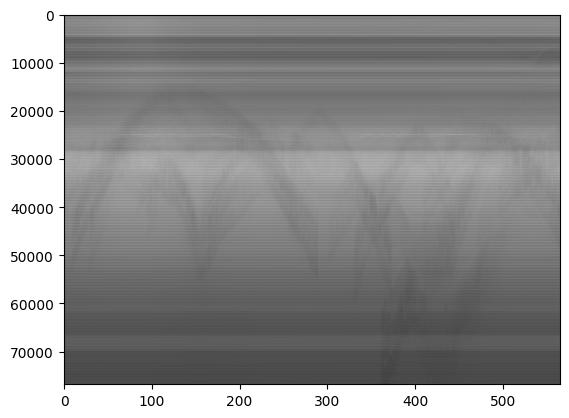

In [3]:
print(M.shape)
plt.imshow(M, cmap='gray', aspect='auto')

The wavy lines are the people moving and the horizontal lines are the background. The columns are moments in time.

## Implementing Randomized SVD

In [4]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    """
    Step1: 
        - Take a random projection matrix (P) and sample column space of M to go to lower dimension (Z).
        - Z will probabilistically have the same column space as M.
        - Use QR factorization to find orthonormal basis of Z.
        - Range of Q will approximate range of M
    """
    print("randomized_svd: Shape of M:", M.shape)
    ny = M.shape[1]
    
    # Generating a random projection matrix.
    P = np.random.randn(ny, n_components + n_oversamples)

    # Shrinking column space of M. Since P is random, with high probability 
    # we will sample all columns of M, so Z and M will have same dominant column space.
    Z = M @ P
    # Performing power iterations to make singular values drop faster.
    for i in range (n_iter):
        Z = M @ (M.T @ Z)
        
    print("randomized_svd: Shape of P:", P.shape)
    print("randomized_svd: Shape of Z:", Z.shape)

    # Finding QR factorization of M to find orthonormal basis for Z (and hopefully M)
    Q, R = np.linalg.qr(Z, mode = 'reduced')

    """
    Step2: 
        - Project M onto Q, reducing its dimension. Call this Y.
        - Compute SVD of this thin matrix Y.
        - Lift the singular vectors back to high dimensional
    """
    Y = Q.T @ M

    # S and V of Y is same as S and V of M because 
    # UY is an orthonormal basis that spans the columns of M
    UY, S, VT = np.linalg.svd(Y, full_matrices=0)

    # Lift the small singular vectors (UY) back to high dimensional space through Q.
    U = Q @ UY
    return U[:, :n_components], S[:n_components], VT[:n_components, :]

## Applying Randomized SVD on M

In [5]:
from sklearn import decomposition

u,s,v = randomized_svd(M, 1)
# u,s,v = decomposition.randomized_svd(M, 1)
u.shape, s.shape, v.shape

randomized_svd: Shape of M: (76800, 565)
randomized_svd: Shape of P: (565, 11)
randomized_svd: Shape of Z: (76800, 11)


((76800, 1), (1,), (1, 565))

Shape of low rank matrix: (76800, 565)


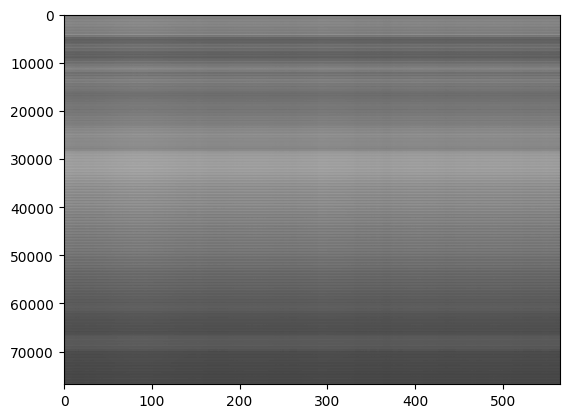

In [6]:
low_rank = u @ np.diag(s) @ v  # Background
print("Shape of low rank matrix:", low_rank.shape)
plt.imshow(low_rank, cmap='gray', aspect = 'auto')

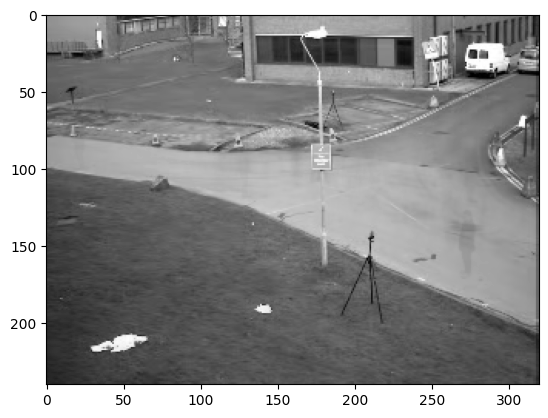

In [7]:
plt.imshow(np.reshape(low_rank[:,550], dims), cmap='gray');

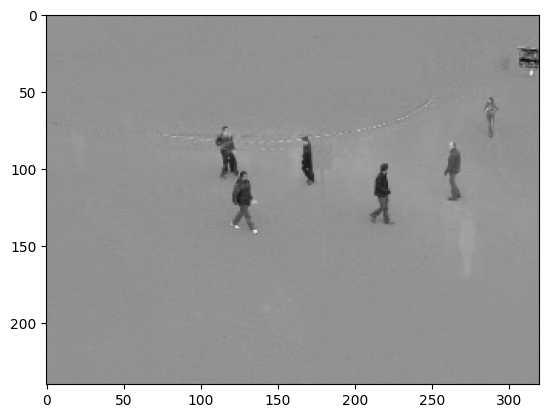

In [8]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');